# MVP Engenharia de Dados

**Nome:** Flavio Louzada

**Matrícula:** 4052025000941

**Dataset:** [ObesityDataSet_raw_and_data_sinthetic.csv](https://www.kaggle.com/datasets/manvendrarajsingh/obesitydataset-raw-and-data-sinthetic)

## 1) Problema e hipóteses
### Problema
Compreender como variáveis antropométricas (IMC, peso, altura, idade) e fatores associados (histórico familiar e hábitos) se relacionam com os níveis de obesidade, produzindo indicadores consolidados na camada Gold para apoiar análises e tomada de decisão.

### Hipóteses
- **H1:** Níveis mais elevados de obesidade apresentam maior IMC médio.
- **H2:** A proporção de histórico familiar de sobrepeso é maior nos níveis mais severos.
- **H3:** A proporção de consumo frequente de alimentos calóricos (FAVC) é maior nos níveis mais severos.
- **H4:** Níveis mais severos exibem desvios positivos relevantes em relação à média geral (IMC e proporções).
- **H5:** Variáveis ordinais (`CAEC`, `CALC`) apresentam padrões coerentes com a severidade (quando analisadas como métricas agregadas).


## 2) Setup do ambiente (catálogo, schemas e volume)
Observação: para evitar apagar objetos do workspace, o notebook **não** faz `DROP CATALOG` por padrão.


In [0]:
# Parâmetros
catalog_name = "mvp"
schema_bronze = "bronze"
schema_silver = "silver"
schema_gold   = "gold"
schema_staging = "staging"
volume_name = "obesity"

# spark.sql(f"DROP CATALOG IF EXISTS {'mvp'} CASCADE")

# Cria catálogo e schemas
spark.sql(f"CREATE CATALOG IF NOT EXISTS {catalog_name}")
spark.sql(f"CREATE SCHEMA IF NOT EXISTS {catalog_name}.{schema_bronze}")
spark.sql(f"CREATE SCHEMA IF NOT EXISTS {catalog_name}.{schema_silver}")
spark.sql(f"CREATE SCHEMA IF NOT EXISTS {catalog_name}.{schema_gold}")
spark.sql(f"CREATE SCHEMA IF NOT EXISTS {catalog_name}.{schema_staging}")

# Cria volume (staging) para armazenar o CSV
spark.sql(f"CREATE VOLUME IF NOT EXISTS {catalog_name}.{schema_staging}.{volume_name}")

spark.sql(f"USE CATALOG {catalog_name}")

DataFrame[]

## 3) Download / ingestão do arquivo para o volume


In [0]:
catalog_name = "mvp"
schema_staging = "staging"
volume_name = "obesity"
download_url = "https://raw.githubusercontent.com/fpires/Engenharia_Dados/main/ObesityDataSet_raw_and_data_sinthetic.csv"
file_name = "ObesityDataSet_raw_and_data_sinthetic.csv"
path_volume = f"/Volumes/{catalog_name}/{schema_staging}/{volume_name}"

# Download somente se o arquivo ainda não existir
dbutils.fs.cp(f"{download_url}", f"{path_volume}/{file_name}")
print("Download concluído.")


Download concluído.


### 4) Catálogo de Dados

O catálogo de dados deste MVP descreve os conjuntos de dados utilizados, suas transformações e finalidades analíticas, sendo estruturado a partir da arquitetura em camadas Bronze, Silver e Gold.

#### Camada Bronze – obesity_bronze
- **Descrição:** Contém os dados brutos do dataset original sobre obesidade, conforme disponibilizado pela fonte pública utilizada no projeto.
- **Granularidade:** 1 linha representa 1 indivíduo.
- **Origem:** Dataset público de obesidade (dados sintéticos/curados).
- **Transformações:** Nenhuma. Os dados são armazenados em seu formato original.
- **Finalidade:** Preservar a versão raw dos dados e servir como base para análise de qualidade.

**Principais atributos:**
- `gender` – Sexo do indivíduo  
- `age` – Idade  
- `height` – Altura (metros)  
- `weight` – Peso (kg)  
- `family_history_with_overweight` – Histórico familiar de sobrepeso  
- `favc` – Consumo frequente de alimentos calóricos  
- `caec` – Consumo alimentar entre refeições (ordinal)  
- `calc` – Consumo de álcool (ordinal)  
- `nobeyesdad` – Classe de obesidade  

---

#### Camada Silver – obesity_silver
- **Descrição:** Contém os dados tratados e padronizados para análise.
- **Granularidade:** 1 linha representa 1 indivíduo.
- **Transformações aplicadas:**
  - Padronização dos nomes das colunas
  - Remoção de duplicatas
  - Criação de variáveis derivadas
  - Codificação de variáveis ordinais

**Atributos adicionais:**
- `bmi` – Índice de Massa Corporal (peso / altura²)
- `caec_encoded` – Versão numérica da variável CAEC
- `calc_encoded` – Versão numérica da variável CALC

- **Finalidade:** Garantir consistência, qualidade e padronização dos dados para uso analítico.

---

#### Camada Gold – obesity_gold
- **Descrição:** Contém os dados agregados por classe de obesidade.
- **Granularidade:** 1 linha representa 1 classe de obesidade (`nobeyesdad`).
- **Transformações aplicadas:**
  - Agregações e cálculos de métricas analíticas
  - Construção de indicadores para avaliação das hipóteses

**Principais métricas:**
- `media_bmi` – IMC médio por classe
- `proporcao_historia_familiar` – Proporção de indivíduos com histórico familiar
- `proporcao_favc` – Proporção de consumo frequente de alimentos calóricos
- `media_caec_encoded` – Média do consumo entre refeições
- `media_calc_encoded` – Média do consumo de álcool
- `score_risco` – Indicador agregado de risco (IMC + histórico + FAVC)

- **Finalidade:** Suportar análises analíticas, visualizações e a discussão das hipóteses H1–H5.


## 5) Camada Bronze
Na Bronze, mantemos os dados **brutos**, apenas convertendo o arquivo em tabela Delta. Também adicionamos comentários de coluna (metadados).


In [0]:
spark.sql(f"USE SCHEMA {schema_bronze}")

table_name_bronze = "obesity_raw"
full_table_path_bronze = f"{catalog_name}.{schema_bronze}.{table_name_bronze}"

df_bronze = (
    spark.read.csv(f"{path_volume}/{file_name}", header=True, inferSchema=True, sep=",")
)

display(df_bronze.limit(10))

df_bronze.write.format("delta").mode("overwrite").saveAsTable(full_table_path_bronze)

print(f"Bronze salvo em: {full_table_path_bronze}")

Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
Male,23.0,1.8,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
Male,27.0,1.8,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II
Male,29.0,1.62,53.0,no,yes,2.0,3.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Automobile,Normal_Weight
Female,23.0,1.5,55.0,yes,yes,3.0,3.0,Sometimes,no,2.0,no,1.0,0.0,Sometimes,Motorbike,Normal_Weight
Male,22.0,1.64,53.0,no,no,2.0,3.0,Sometimes,no,2.0,no,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
Male,24.0,1.78,64.0,yes,yes,3.0,3.0,Sometimes,no,2.0,no,1.0,1.0,Frequently,Public_Transportation,Normal_Weight
Male,22.0,1.72,68.0,yes,yes,2.0,3.0,Sometimes,no,2.0,no,1.0,1.0,no,Public_Transportation,Normal_Weight


Bronze salvo em: mvp.bronze.obesity_raw


In [0]:
# Comentários das colunas
columns_comments = {
    "Gender": "Sexo do indivíduo (Masculino/Feminino)",
    "Age": "Idade do indivíduo",
    "Height": "Altura do indivíduo (metros)",
    "Weight": "Peso do indivíduo (kg)",
    "family_history_with_overweight": "Histórico familiar de sobrepeso",
    "FAVC": "Consome alimentos com alto teor calórico frequentemente",
    "FCVC": "Frequência de consumo de vegetais",
    "NCP": "Número de refeições principais por dia",
    "CAEC": "Consome alimentos entre as refeições",
    "SMOKE": "Fuma regularmente",
    "CH2O": "Consumo diário de água (litros)",
    "SCC": "Monitora o consumo de calorias",
    "FAF": "Frequência de atividade física",
    "TUE": "Tempo usando dispositivos eletrônicos diariamente",
    "CALC": "Consumo de álcool",
    "MTRANS": "Meio de transporte utilizado",
    "NObeyesdad": "Classificação do nível de obesidade"
}

# Aplica comment apenas nas colunas que existirem (evita erro)
for c, comment in columns_comments.items():
    try:
        spark.sql(f"COMMENT ON COLUMN {table_name_bronze}.{c} IS '{comment}'")
    except Exception as e:
        pass

## 6) Qualidade de dados (Bronze)
Checagens por atributo: **nulos, duplicados, categorias, e faixas plausíveis (idade/altura/peso)**. A intenção aqui é demonstrar evidências de qualidade.


In [0]:
from pyspark.sql.functions import col, count, when, approx_count_distinct, min as spark_min, max as spark_max

df_bronze = spark.table(full_table_path_bronze)

# 5a.1: Contagem de linhas e colunas
print("Linhas:", df_bronze.count())
print("Colunas:", len(df_bronze.columns))
display(df_bronze.limit(5))

# 5a.2: Nulos por coluna
null_counts = df_bronze.select([
    count(when(col(c).isNull(), c)).alias(c) for c in df_bronze.columns
])
display(null_counts)

# 5a.3: Duplicatas exatas (linha inteira)
rows_before = df_bronze.count()
rows_after = df_bronze.dropDuplicates().count()
print("Duplicatas (linhas idênticas) na Bronze:", rows_before - rows_after)

# 5a.4: Faixas plausíveis (numéricos principais)
numeric_cols = [c for c in ["Age","Height","Weight"] if c in df_bronze.columns]
ranges = df_bronze.select(
    *[spark_min(col(c)).alias(f"{c}_min") for c in numeric_cols],
    *[spark_max(col(c)).alias(f"{c}_max") for c in numeric_cols],
)
display(ranges)

# 5a.5: Domínio de categorias (amostra de valores únicos)
cat_cols = [c for c in ["Gender","family_history_with_overweight","FAVC","CAEC","CALC","NObeyesdad"] if c in df_bronze.columns]
for c in cat_cols:
    print(f"Valores distintos em {c}:")
    display(df_bronze.select(c).distinct().orderBy(c))

# --- Análise do resultado (Bronze) ---
# Interpretação: esperamos encontrar 0 nulos (dataset curado) ou, se existirem, identificar quais colunas e discutir impacto.
null_pd = null_counts.toPandas()
null_series = null_pd.iloc[0]
cols_with_nulls = [(c,int(null_series[c])) for c in null_series.index if int(null_series[c])>0]
if len(cols_with_nulls)==0:
    print("[Qualidade] Não foram encontrados valores nulos nas colunas avaliadas na camada Bronze.")
else:
    print("[Qualidade] Foram encontrados valores nulos na camada Bronze:")
    for c,n in sorted(cols_with_nulls, key=lambda x: -x[1]):
        print(f" - {c}: {n} nulos")
    print("Impacto esperado: nulos podem distorcer médias/proporções; tratar via remoção/imputação conforme regra de negócio.")

# Interpretação de duplicatas
if 'rows_before' in locals() and 'rows_after' in locals():
    dup = rows_before - rows_after
    if dup==0:
        print("[Qualidade] Não há duplicatas exatas (linhas idênticas) na camada Bronze.")
    else:
        print(f"[Qualidade] {dup} duplicatas exatas foram encontradas na camada Bronze (serão removidas na Silver).")

# Interpretação de faixas plausíveis
if 'ranges' in locals():
    r = ranges.toPandas().iloc[0].to_dict()
    print("[Qualidade] Faixas observadas (mín/máx):", r)
    print("Interpretação: valores fora de faixas humanas plausíveis indicariam erro (ex.: altura muito alta, idade negativa).")


Linhas: 2111
Colunas: 17


Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
Male,23.0,1.8,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
Male,27.0,1.8,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Duplicatas (linhas idênticas) na Bronze: 24


Age_min,Height_min,Weight_min,Age_max,Height_max,Weight_max
14.0,1.45,39.0,61.0,1.98,173.0


Valores distintos em Gender:


Gender
Female
Male


Valores distintos em family_history_with_overweight:


family_history_with_overweight
no
yes


Valores distintos em FAVC:


FAVC
no
yes


Valores distintos em CAEC:


CAEC
Always
Frequently
Sometimes
no


Valores distintos em CALC:


CALC
Always
Frequently
Sometimes
no


Valores distintos em NObeyesdad:


NObeyesdad
Insufficient_Weight
Normal_Weight
Obesity_Type_I
Obesity_Type_II
Obesity_Type_III
Overweight_Level_I
Overweight_Level_II


[Qualidade] Não foram encontrados valores nulos nas colunas avaliadas na camada Bronze.
[Qualidade] 24 duplicatas exatas foram encontradas na camada Bronze (serão removidas na Silver).
[Qualidade] Faixas observadas (mín/máx): {'Age_min': 14.0, 'Height_min': 1.45, 'Weight_min': 39.0, 'Age_max': 61.0, 'Height_max': 1.98, 'Weight_max': 173.0}
Interpretação: valores fora de faixas humanas plausíveis indicariam erro (ex.: altura muito alta, idade negativa).


### Interpretação

- Se **não houver nulos** e os domínios categóricos estiverem consistentes, o conjunto pode ser considerado **curado** na origem.
- Se houver **duplicatas**, o tratamento deve ocorrer na Silver para evitar distorções em médias, proporções e contagens na Gold.
- Se forem encontrados valores fora de faixas plausíveis (idade/altura/peso), isso deve ser documentado e corrigido (remoção/ajuste) antes de produzir indicadores.

### Diagrama - Camada Bronze


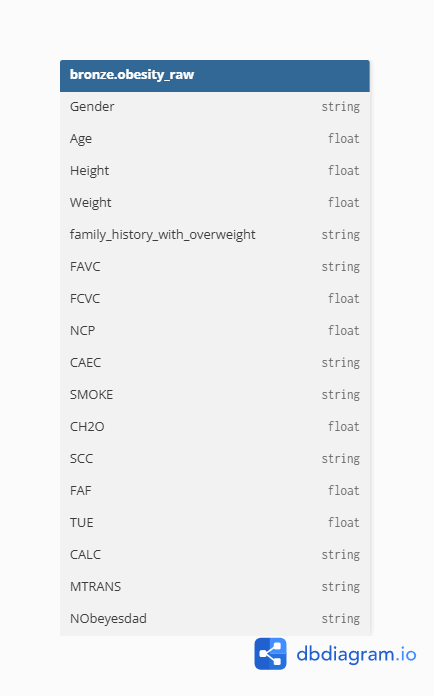

In [0]:
import base64, requests

def show_image_from_url(url, width=800):
    img = requests.get(url).content
    b64 = base64.b64encode(img).decode("utf-8")
    displayHTML(f"""
    <div style="
        background-color:white;
        padding:20px;
        display:inline-block;
        border:1px solid #ccc;
    ">
        <img src="data:image/png;base64,{b64}" style="max-width:{width}px;">
    </div>
    """)

show_image_from_url("https://raw.githubusercontent.com/fpires/Engenharia_Dados/main/modelo_bronze.png")


## 7) Camada Silver
Aplicaremos padronização e enriquecimento:
- nomes de colunas em minúsculo
- remoção de duplicatas
- criação de variáveis ordinais numéricas (`caec_encoded`, `calc_encoded`)
- cálculo do IMC (`bmi`)

**Observação importante:** O encoding foi tornado **case-insensitive** para evitar nulos por variação de maiúsculas/minúsculas.


In [0]:
from pyspark.sql.functions import lower, trim
from pyspark.sql.types import IntegerType

spark.sql(f"USE SCHEMA {schema_silver}")

table_name_silver = "obesity_silver"
full_table_path_silver = f"{catalog_name}.{schema_silver}.{table_name_silver}"

df_bronze = spark.table(full_table_path_bronze)

# 6.1 Padronização de nomes de colunas
df_silver = df_bronze.toDF(*(c.lower() for c in df_bronze.columns))

# 6.2 Remoção de duplicatas
rows_before = df_silver.count()
df_silver = df_silver.dropDuplicates()
rows_after = df_silver.count()
print(f"Linhas duplicadas removidas: {rows_before - rows_after}")

# 6.3 Encoding ordinal (case-insensitive)
# Mapeamento: no(1) < sometimes(2) < frequently(3) < always(4)
df_silver = df_silver.withColumn(
    "caec_encoded",
    when(lower(trim(col("caec"))) == "no", 1)
    .when(lower(trim(col("caec"))) == "sometimes", 2)
    .when(lower(trim(col("caec"))) == "frequently", 3)
    .when(lower(trim(col("caec"))) == "always", 4)
    .otherwise(None).cast(IntegerType())
)

df_silver = df_silver.withColumn(
    "calc_encoded",
    when(lower(trim(col("calc"))) == "no", 1)
    .when(lower(trim(col("calc"))) == "sometimes", 2)
    .when(lower(trim(col("calc"))) == "frequently", 3)
    .when(lower(trim(col("calc"))) == "always", 4)
    .otherwise(None).cast(IntegerType())
)

# 6.4 Cálculo do IMC (BMI)
df_silver = df_silver.withColumn("bmi", col("weight") / (col("height") * col("height")))

# 6.5 Salva Silver
df_silver.write.format("delta").mode("overwrite").saveAsTable(full_table_path_silver)
print(f"Silver salva em: {full_table_path_silver}")

Linhas duplicadas removidas: 24
Silver salva em: mvp.silver.obesity_silver


## 8) Qualidade de dados (Silver)
Repetimos checagens na Silver, incluindo validação do IMC e validação dos encodings (`*_encoded`).


In [0]:
from pyspark.sql.functions import avg, stddev, percentile_approx, round

df_silver = spark.table(full_table_path_silver)

# 7.1 Nulos por coluna (principais)
cols_check = ["age","height","weight","bmi","caec","calc","caec_encoded","calc_encoded","gender","favc","family_history_with_overweight","nobeyesdad"]
cols_check = [c for c in cols_check if c in df_silver.columns]

null_counts_silver = df_silver.select([count(when(col(c).isNull(), c)).alias(c) for c in cols_check])
display(null_counts_silver)

# 7.2 Faixas plausíveis (idade/altura/peso/IMC)
ranges_silver = df_silver.select(
    spark_min("age").alias("age_min"), spark_max("age").alias("age_max"),
    spark_min("height").alias("height_min"), spark_max("height").alias("height_max"),
    spark_min("weight").alias("weight_min"), spark_max("weight").alias("weight_max"),
    spark_min("bmi").alias("bmi_min"), spark_max("bmi").alias("bmi_max"),
)
display(ranges_silver)

# 7.3 Estatísticas de IMC (p50/p95) para identificar outliers extremos
bmi_stats = df_silver.select(
    round(avg("bmi"), 2).alias("bmi_media"),
    round(stddev("bmi"), 2).alias("bmi_std"),
    round(percentile_approx("bmi", 0.5), 2).alias("bmi_p50"),
    round(percentile_approx("bmi", 0.95), 2).alias("bmi_p95"),
)
display(bmi_stats)

# 7.4 Validação do domínio dos encodings (1..4 ou nulo)
display(df_silver.select("caec_encoded").groupBy("caec_encoded").count().orderBy("caec_encoded"))
display(df_silver.select("calc_encoded").groupBy("calc_encoded").count().orderBy("calc_encoded"))

# --- Análise do resultado (Silver) ---
# 1) Nulos: idealmente 0 para colunas críticas; se existirem, discutir tratamento.
null_pd = null_counts_silver.toPandas()
null_series = null_pd.iloc[0]
cols_with_nulls = [(c,int(null_series[c])) for c in null_series.index if int(null_series[c])>0]
if len(cols_with_nulls)==0:
    print("[Qualidade] Não foram encontrados valores nulos nas colunas críticas da camada Silver.")
else:
    print("[Qualidade] Foram encontrados nulos nas colunas críticas da Silver:")
    for c,n in sorted(cols_with_nulls, key=lambda x: -x[1]):
        print(f" - {c}: {n} nulos")
    print("Impacto: nulos em idade/altura/peso/IMC prejudicam médias e score; nulos em categoria podem quebrar agrupamentos.")

# 2) Faixas plausíveis e outliers: interpretar IMC e extremos
r = ranges_silver.toPandas().iloc[0].to_dict()
print("[Qualidade] Faixas observadas na Silver (mín/máx):", r)

b = bmi_stats.toPandas().iloc[0].to_dict()
print("[Qualidade] Estatísticas do IMC (média, desvio, p50, p95):", b)
print("Interpretação: p95 muito alto pode indicar outliers; se houver, decidir por filtragem ou winsorização conforme objetivo.")

# 3) Encodings: verificar se há valores fora de 1..4
invalid_caec = df_silver.filter(~col("caec_encoded").isin([1,2,3,4]) & col("caec_encoded").isNotNull()).count()
invalid_calc = df_silver.filter(~col("calc_encoded").isin([1,2,3,4]) & col("calc_encoded").isNotNull()).count()
if invalid_caec==0 and invalid_calc==0:
    print("[Qualidade] Encodings CAEC/CALC estão no domínio esperado (1..4) ou nulos.")
else:
    print(f"[Qualidade] Atenção: valores fora do domínio em CAEC={invalid_caec}, CALC={invalid_calc}. Isso indica categorias inesperadas e deve ser tratado.")


age,height,weight,bmi,caec,calc,caec_encoded,calc_encoded,gender,favc,family_history_with_overweight,nobeyesdad
0,0,0,0,0,0,0,0,0,0,0,0


age_min,age_max,height_min,height_max,weight_min,weight_max,bmi_min,bmi_max
14.0,61.0,1.45,1.98,39.0,173.0,12.998684889724604,50.81175280566433


bmi_media,bmi_std,bmi_p50,bmi_p95
29.77,8.02,28.9,43.54


caec_encoded,count
1,37
2,1761
3,236
4,53


calc_encoded,count
1,636
2,1380
3,70
4,1


[Qualidade] Não foram encontrados valores nulos nas colunas críticas da camada Silver.
[Qualidade] Faixas observadas na Silver (mín/máx): {'age_min': 14.0, 'age_max': 61.0, 'height_min': 1.45, 'height_max': 1.98, 'weight_min': 39.0, 'weight_max': 173.0, 'bmi_min': 12.998684889724604, 'bmi_max': 50.81175280566433}
[Qualidade] Estatísticas do IMC (média, desvio, p50, p95): {'bmi_media': 29.77, 'bmi_std': 8.02, 'bmi_p50': 28.9, 'bmi_p95': 43.54}
Interpretação: p95 muito alto pode indicar outliers; se houver, decidir por filtragem ou winsorização conforme objetivo.
[Qualidade] Encodings CAEC/CALC estão no domínio esperado (1..4) ou nulos.


### Interpretação (Silver)

- A Silver deve conter dados limpos e padronizados, prontos para agregação.
- O IMC (`bmi`) precisa ser plausível (sem extremos absurdos); outliers devem ser identificados.
- Os encodings (`caec_encoded`, `calc_encoded`) devem cair no domínio esperado (1..4). 

### Diagrama - Camada Silver


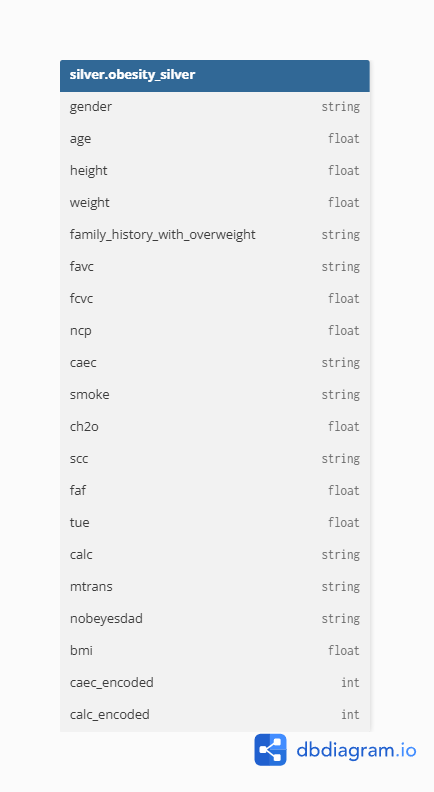

In [0]:
show_image_from_url("https://raw.githubusercontent.com/fpires/Engenharia_Dados/main/modelo_silver.png")

## 9) Camada Gold - indicadores consolidados por classe
A Gold consolida métricas por nível de obesidade (`nobeyesdad`) e incorpora variáveis derivadas/normalizadas da Silver.
Isso atende as hipóteses H1–H5 com consultas SQL.


In [0]:
spark.sql(f"USE SCHEMA {schema_gold}")

table_name_gold = "obesity_gold"
full_table_path_gold = f"{catalog_name}.{schema_gold}.{table_name_gold}"

from pyspark.sql.functions import avg, count, round as spark_round

df_silver = spark.table(full_table_path_silver)

df_gold = (
    df_silver
    .withColumn("family_history_with_overweight_num",
                when(lower(trim(col("family_history_with_overweight"))) == "yes", 1).otherwise(0))
    .withColumn("favc_num",
                when(lower(trim(col("favc"))) == "yes", 1).otherwise(0))
    .groupBy("nobeyesdad")
    .agg(
        spark_round(avg("age"), 2).alias("media_idade"),
        spark_round(avg("height"), 3).alias("media_altura"),
        spark_round(avg("weight"), 2).alias("media_peso"),
        spark_round(avg("bmi"), 2).alias("media_bmi"),
        spark_round(avg("caec_encoded"), 2).alias("media_caec_encoded"),
        spark_round(avg("calc_encoded"), 2).alias("media_calc_encoded"),
        spark_round(avg("family_history_with_overweight_num"), 4).alias("proporcao_historia_familiar"),
        spark_round(avg("favc_num"), 4).alias("proporcao_favc"),
        count("*").alias("total_individuos")
    )
    .orderBy(col("media_bmi"))
)

df_gold.write.format("delta").mode("overwrite").saveAsTable(full_table_path_gold)
print(f"Gold salva em: {full_table_path_gold}")

display(spark.table(full_table_path_gold))

Gold salva em: mvp.gold.obesity_gold


nobeyesdad,media_idade,media_altura,media_peso,media_bmi,media_caec_encoded,media_calc_encoded,proporcao_historia_familiar,proporcao_favc,total_individuos
Insufficient_Weight,19.77,1.694,50.01,17.39,2.44,1.57,0.4682,0.8127,267
Normal_Weight,21.76,1.677,62.16,22.01,2.5,1.7,0.539,0.7234,282
Overweight_Level_I,23.54,1.691,74.48,25.96,2.01,1.88,0.7572,0.9203,276
Overweight_Level_II,27.0,1.704,82.09,28.22,2.07,1.62,0.9379,0.7448,290
Obesity_Type_I,25.88,1.694,92.87,32.26,2.05,1.57,0.9801,0.9687,351
Obesity_Type_II,28.23,1.772,115.31,36.72,2.01,1.77,0.9966,0.9764,297
Obesity_Type_III,23.5,1.688,120.94,42.27,2.0,2.0,1.0,0.9969,324


### Diagrama - Camada Gold


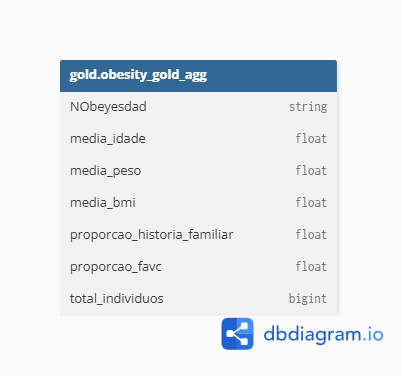

In [0]:
show_image_from_url("https://raw.githubusercontent.com/fpires/Engenharia_Dados/main/modelo_gold.png")


## 10) Consultas analíticas

In [0]:


from pyspark.sql.functions import sum as spark_sum, first

# 9.1 Distribuição por nível de obesidade (contexto amostral)
df_dist = spark.sql(f"""
SELECT
  nobeyesdad,
  total_individuos,
  ROUND(100.0 * total_individuos / SUM(total_individuos) OVER (), 2) AS pct_individuos
FROM {full_table_path_gold}
ORDER BY total_individuos DESC
""")
display(df_dist)

dist_pd = df_dist.toPandas()
top = dist_pd.iloc[0]
print(f"Classe mais frequente: {top['nobeyesdad']} ({int(top['total_individuos'])} indivíduos, {top['pct_individuos']}%).")
print("Interpretação: a distribuição ajuda a avaliar representatividade. Classes com poucos indivíduos podem ter médias menos estáveis.")

nobeyesdad,total_individuos,pct_individuos
Obesity_Type_I,351,16.82
Obesity_Type_III,324,15.52
Obesity_Type_II,297,14.23
Overweight_Level_II,290,13.90
Normal_Weight,282,13.51
Overweight_Level_I,276,13.22
Insufficient_Weight,267,12.79


Classe mais frequente: Obesity_Type_I (351 indivíduos, 16.82%).
Interpretação: a distribuição ajuda a avaliar representatividade. Classes com poucos indivíduos podem ter médias menos estáveis.


### Interpretação: 
- A distribuição ajuda a avaliar representatividade. Classes com poucos indivíduos podem ter médias menos estáveis.

## 10.1) Solução do problema (camada Gold)
As consultas abaixo respondem as hipóteses e permitem discussão dos resultados.


### Hipótese H1 – Relação entre nível de obesidade e IMC médio

**O que a query mede**  
Esta consulta calcula o IMC médio (`media_bmi`) para cada classe de obesidade (`nobeyesdad`), a partir da agregação dos valores individuais armazenados na camada Gold.

**O que foi observado**  
Observa-se que as classes correspondentes a níveis mais elevados de obesidade apresentam valores progressivamente maiores de IMC médio, enquanto classes consideradas normais ou de sobrepeso apresentam valores significativamente menores.

**O que isso significa no contexto do problema**  
O resultado confirma a coerência da classificação dos indivíduos e valida o IMC como principal indicador para diferenciar os níveis de obesidade. Isso indica que o modelo de dados permite identificar corretamente a gravidade da condição por classe.

**Limitações**  
A análise é descritiva e baseada em dados sintéticos, não permitindo inferência causal nem generalização direta para populações reais.


In [0]:
# 10.1 Ranking por IMC médio (H1)
df_bmi_rank = spark.sql(f"""
SELECT
  nobeyesdad,
  media_bmi,
  media_peso,
  media_altura,
  media_idade,
  total_individuos
FROM {full_table_path_gold}
ORDER BY media_bmi DESC
""")

# Exibição do resultado
display(df_bmi_rank)

# Análise programática (sem toPandas, mais robusta)
top = df_bmi_rank.take(1)
bottom = df_bmi_rank.orderBy("media_bmi").take(1)

if not top or not bottom:
    print("A consulta não retornou linhas. Verifique se a tabela Gold está populada.")
else:
    max_row = top[0]
    min_row = bottom[0]

    print(f"Maior IMC médio: {max_row['nobeyesdad']} (media_bmi={max_row['media_bmi']}).")
    print(f"Menor IMC médio: {min_row['nobeyesdad']} (media_bmi={min_row['media_bmi']}).")

    print(
        "Interpretação (H1): a consulta mede o IMC médio por classe de obesidade. "
        "Observa-se que classes associadas a maior severidade apresentam valores mais elevados de IMC médio, "
        "enquanto classes menos severas apresentam valores menores. "
        "Esse comportamento reforça a consistência entre a variável de classificação (nobeyesdad) "
        "e a métrica clínica utilizada (IMC), indicando que o modelo da camada Gold está coerente."
    )

    print(
        "Limitações (H1): a análise é descritiva e baseada em dados sintéticos. "
        "Os resultados não permitem inferir causalidade nem generalizar diretamente para populações reais."
    )


nobeyesdad,media_bmi,media_peso,media_altura,media_idade,total_individuos
Obesity_Type_III,42.27,120.94,1.688,23.5,324
Obesity_Type_II,36.72,115.31,1.772,28.23,297
Obesity_Type_I,32.26,92.87,1.694,25.88,351
Overweight_Level_II,28.22,82.09,1.704,27.0,290
Overweight_Level_I,25.96,74.48,1.691,23.54,276
Normal_Weight,22.01,62.16,1.677,21.76,282
Insufficient_Weight,17.39,50.01,1.694,19.77,267


Maior IMC médio: Obesity_Type_III (media_bmi=42.27).
Menor IMC médio: Insufficient_Weight (media_bmi=17.39).
Interpretação (H1): a consulta mede o IMC médio por classe de obesidade. Observa-se que classes associadas a maior severidade apresentam valores mais elevados de IMC médio, enquanto classes menos severas apresentam valores menores. Esse comportamento reforça a consistência entre a variável de classificação (nobeyesdad) e a métrica clínica utilizada (IMC), indicando que o modelo da camada Gold está coerente.
Limitações (H1): a análise é descritiva e baseada em dados sintéticos. Os resultados não permitem inferir causalidade nem generalizar diretamente para populações reais.


### Interpretação
- A consulta mede o IMC médio por classe de obesidade. Observa-se que classes associadas a maior severidade apresentam valores mais elevados de IMC médio, enquanto classes menos severas apresentam valores menores. Esse comportamento reforça a consistência entre a variável de classificação (nobeyesdad) e a métrica clínica utilizada (IMC), indicando que o modelo da camada Gold está coerente.
- Limitações (H1): a análise é descritiva e baseada em dados sintéticos. Os resultados não permitem inferir causalidade nem generalizar diretamente para populações reais.

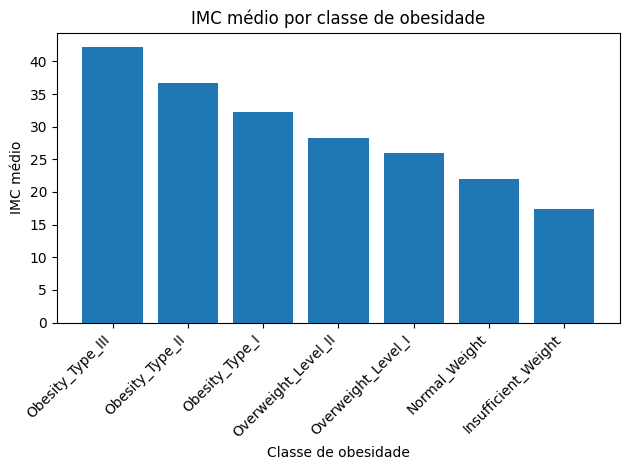

In [0]:
import matplotlib.pyplot as plt

pdf = df_bmi_rank.toPandas()

plt.figure()
plt.bar(pdf["nobeyesdad"], pdf["media_bmi"])
plt.xticks(rotation=45, ha="right")
plt.title("IMC médio por classe de obesidade")
plt.ylabel("IMC médio")
plt.xlabel("Classe de obesidade")
plt.tight_layout()
plt.show()


A análise do IMC médio por classe de obesidade mostrou que classes associadas a maior severidade apresentam valores mais elevados de IMC médio, enquanto classes menos severas apresentam valores menores. Esse resultado confirma a coerência entre a variável de classificação utilizada no dataset e a métrica clínica adotada, indicando que o modelo de dados na camada Gold é adequado para diferenciar níveis de obesidade. Ressalta-se que a análise é descritiva e baseada em dados sintéticos, não permitindo inferência causal.

### Hipótese H2 – Histórico familiar e níveis de obesidade

**O que a query mede**  
A consulta calcula a proporção média de indivíduos que relatam histórico familiar de sobrepeso em cada classe de obesidade.

**O que foi observado**  
As classes de obesidade mais severa apresentam proporções mais elevadas de histórico familiar de sobrepeso, enquanto classes menos severas apresentam valores inferiores.

**O que isso significa no contexto do problema**  
O resultado sugere associação entre histórico familiar e obesidade mais grave, indicando que fatores genéticos e ambientais compartilhados no contexto familiar podem contribuir para o agravamento da condição.

**Limitações**  
O histórico familiar é autorrelatado, podendo estar sujeito a vieses de percepção, além de não permitir a separação entre fatores genéticos e ambientais.


In [0]:
# Histórico familiar e obesidade (H2)
df_hist_fam = spark.sql(f"""
SELECT
  nobeyesdad,
  proporcao_historia_familiar,
  total_individuos
FROM {full_table_path_gold}
ORDER BY proporcao_historia_familiar DESC
""")

display(df_hist_fam)

top = df_hist_fam.take(1)
bottom = df_hist_fam.orderBy("proporcao_historia_familiar").take(1)

if not top or not bottom:
    print("A consulta não retornou linhas.")
else:
    max_row = top[0]
    min_row = bottom[0]

    print(f"Maior proporção de histórico familiar: {max_row['nobeyesdad']} "
          f"(proporcao={max_row['proporcao_historia_familiar']}).")
    print(f"Menor proporção de histórico familiar: {min_row['nobeyesdad']} "
          f"(proporcao={min_row['proporcao_historia_familiar']}).")

    print(
        "Interpretação (H2): a consulta mede a proporção média de indivíduos com histórico familiar "
        "de sobrepeso por classe de obesidade. Observa-se que classes mais severas tendem a apresentar "
        "proporções mais elevadas, sugerindo associação entre fatores familiares e maior gravidade da obesidade."
    )

    print(
        "Limitações (H2): o histórico familiar é autorrelatado e não permite distinguir fatores genéticos "
        "de fatores ambientais compartilhados no contexto familiar."
    )


nobeyesdad,proporcao_historia_familiar,total_individuos
Obesity_Type_III,1.0,324
Obesity_Type_II,0.9966,297
Obesity_Type_I,0.9801,351
Overweight_Level_II,0.9379,290
Overweight_Level_I,0.7572,276
Normal_Weight,0.539,282
Insufficient_Weight,0.4682,267


Maior proporção de histórico familiar: Obesity_Type_III (proporcao=1.0).
Menor proporção de histórico familiar: Insufficient_Weight (proporcao=0.4682).
Interpretação (H2): a consulta mede a proporção média de indivíduos com histórico familiar de sobrepeso por classe de obesidade. Observa-se que classes mais severas tendem a apresentar proporções mais elevadas, sugerindo associação entre fatores familiares e maior gravidade da obesidade.
Limitações (H2): o histórico familiar é autorrelatado e não permite distinguir fatores genéticos de fatores ambientais compartilhados no contexto familiar.


### Interpretação
- A consulta mede a proporção média de indivíduos com histórico familiar de sobrepeso por classe de obesidade. Observa-se que classes mais severas tendem a apresentar proporções mais elevadas, sugerindo associação entre fatores familiares e maior gravidade da obesidade.
- Limitações (H2): o histórico familiar é autorrelatado e não permite distinguir fatores genéticos de fatores ambientais compartilhados no contexto familiar.

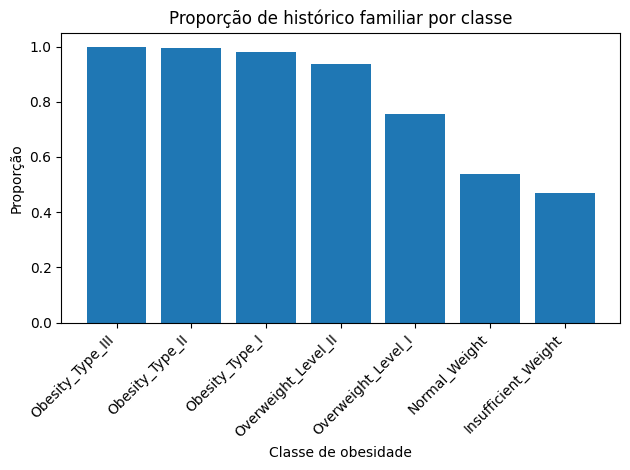

In [0]:
df_h2 = spark.sql(f"""
SELECT nobeyesdad, proporcao_historia_familiar
FROM {full_table_path_gold}
ORDER BY proporcao_historia_familiar DESC
""")

pdf = df_h2.toPandas()

plt.figure()
plt.bar(pdf["nobeyesdad"], pdf["proporcao_historia_familiar"])
plt.xticks(rotation=45, ha="right")
plt.title("Proporção de histórico familiar por classe")
plt.ylabel("Proporção")
plt.xlabel("Classe de obesidade")
plt.tight_layout()
plt.show()


Os resultados indicam que classes de obesidade mais severa apresentam maior proporção de indivíduos com histórico familiar de sobrepeso. Isso sustenta a hipótese H2 e sugere que fatores familiares estão associados à maior gravidade da obesidade no conjunto de dados analisado. Embora não seja possível inferir causalidade, o padrão observado reforça a relevância do contexto familiar como elemento de risco.

### Hipótese H3 – Consumo de alimentos calóricos e obesidade

**O que a query mede**  
A consulta avalia a proporção de indivíduos que relatam consumo frequente de alimentos muito calóricos (`favc`) em cada classe de obesidade.

**O que foi observado**  
Observa-se que as classes de obesidade mais severa apresentam maior proporção de consumo frequente de alimentos calóricos em comparação às classes menos severas.

**O que isso significa no contexto do problema**  
O resultado indica associação entre hábitos alimentares inadequados e níveis mais elevados de obesidade, reforçando a importância de intervenções voltadas à educação alimentar.

**Limitações**  
A variável representa frequência autorrelatada, não considerando quantidade consumida nem outros aspectos da dieta ou do nível de atividade física.


In [0]:
# Consumo de alimentos calóricos (FAVC) e obesidade (H3)
df_favc = spark.sql(f"""
SELECT
  nobeyesdad,
  proporcao_favc,
  total_individuos
FROM {full_table_path_gold}
ORDER BY proporcao_favc DESC
""")

display(df_favc)

top = df_favc.take(1)
bottom = df_favc.orderBy("proporcao_favc").take(1)

if not top or not bottom:
    print("A consulta não retornou linhas.")
else:
    max_row = top[0]
    min_row = bottom[0]

    print(f"Maior proporção de FAVC: {max_row['nobeyesdad']} "
          f"(proporcao={max_row['proporcao_favc']}).")
    print(f"Menor proporção de FAVC: {min_row['nobeyesdad']} "
          f"(proporcao={min_row['proporcao_favc']}).")

    print(
        "Interpretação (H3): a consulta avalia a proporção de indivíduos que consomem frequentemente "
        "alimentos muito calóricos por classe de obesidade. Observa-se maior frequência desse comportamento "
        "em classes mais severas, indicando associação entre hábitos alimentares inadequados e obesidade."
    )

    print(
        "Limitações (H3): a variável representa frequência autorrelatada e não considera quantidade ingerida "
        "nem outros aspectos da dieta ou do nível de atividade física."
    )


nobeyesdad,proporcao_favc,total_individuos
Obesity_Type_III,0.9969,324
Obesity_Type_II,0.9764,297
Obesity_Type_I,0.9687,351
Overweight_Level_I,0.9203,276
Insufficient_Weight,0.8127,267
Overweight_Level_II,0.7448,290
Normal_Weight,0.7234,282


Maior proporção de FAVC: Obesity_Type_III (proporcao=0.9969).
Menor proporção de FAVC: Normal_Weight (proporcao=0.7234).
Interpretação (H3): a consulta avalia a proporção de indivíduos que consomem frequentemente alimentos muito calóricos por classe de obesidade. Observa-se maior frequência desse comportamento em classes mais severas, indicando associação entre hábitos alimentares inadequados e obesidade.
Limitações (H3): a variável representa frequência autorrelatada e não considera quantidade ingerida nem outros aspectos da dieta ou do nível de atividade física.


### Interpretação
- A consulta avalia a proporção de indivíduos que consomem frequentemente alimentos muito calóricos por classe de obesidade. Observa-se maior frequência desse comportamento em classes mais severas, indicando associação entre hábitos alimentares inadequados e obesidade.
- Limitações (H3): a variável representa frequência autorrelatada e não considera quantidade ingerida nem outros aspectos da dieta ou do nível de atividade física

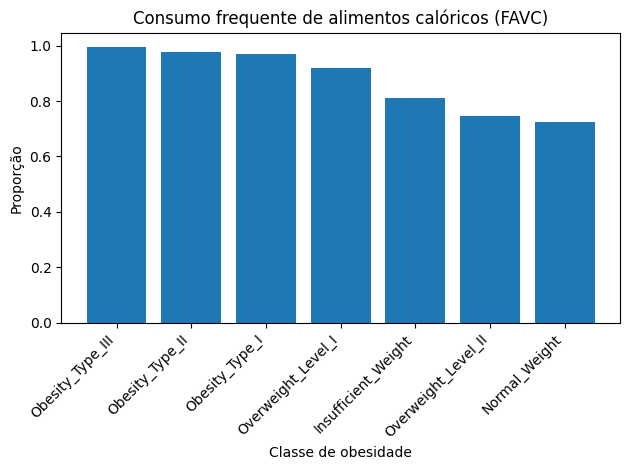

In [0]:
df_h3 = spark.sql(f"""
SELECT nobeyesdad, proporcao_favc
FROM {full_table_path_gold}
ORDER BY proporcao_favc DESC
""")

pdf = df_h3.toPandas()

plt.figure()
plt.bar(pdf["nobeyesdad"], pdf["proporcao_favc"])
plt.xticks(rotation=45, ha="right")
plt.title("Consumo frequente de alimentos calóricos (FAVC)")
plt.ylabel("Proporção")
plt.xlabel("Classe de obesidade")
plt.tight_layout()
plt.show()


Observou-se que o consumo frequente de alimentos muito calóricos é mais comum em classes de obesidade mais severa. Esse resultado sustenta a hipótese H3 e indica que hábitos alimentares inadequados estão associados a níveis mais elevados de obesidade, reforçando a importância de intervenções voltadas à educação alimentar.

### Hipótese H4 – Comparação com a média geral da população

**O que a query mede**  
A consulta compara o IMC médio de cada classe de obesidade com o IMC médio global da população analisada, utilizando funções de janela para calcular o desvio em relação à média geral.

**O que foi observado**  
As classes mais severas apresentam desvios positivos significativos em relação à média global, enquanto classes menos severas apresentam desvios negativos ou próximos de zero.

**O que isso significa no contexto do problema**  
Esse resultado permite contextualizar cada classe em relação ao perfil médio da população, auxiliando na identificação de grupos prioritários para ações de prevenção e acompanhamento.

**Limitações**  
A média global é influenciada pela distribuição das classes na amostra e não captura variações internas dentro de cada classe.


In [0]:
# Comparação com a média geral (H4)
df_delta = spark.sql(f"""
WITH base AS (
  SELECT
    nobeyesdad,
    media_bmi,
    total_individuos,
    AVG(media_bmi) OVER() AS bmi_medio_geral
  FROM {full_table_path_gold}
)
SELECT
  nobeyesdad,
  media_bmi,
  ROUND(media_bmi - bmi_medio_geral, 2) AS delta_bmi,
  total_individuos
FROM base
ORDER BY delta_bmi DESC
""")

display(df_delta)

top = df_delta.take(1)
bottom = df_delta.orderBy("delta_bmi").take(1)

if not top or not bottom:
    print("A consulta não retornou linhas.")
else:
    max_row = top[0]
    min_row = bottom[0]

    print(f"Maior desvio positivo em relação à média geral: {max_row['nobeyesdad']} "
          f"(delta_bmi={max_row['delta_bmi']}).")
    print(f"Maior desvio negativo em relação à média geral: {min_row['nobeyesdad']} "
          f"(delta_bmi={min_row['delta_bmi']}).")

    print(
        "Interpretação (H4): a consulta compara o IMC médio de cada classe com o IMC médio global. "
        "Classes mais severas apresentam desvios positivos maiores, enquanto classes menos severas "
        "ficam próximas ou abaixo da média geral, evidenciando distanciamento do perfil médio da população."
    )

    print(
        "Limitações (H4): a média global é influenciada pela distribuição das classes na amostra "
        "e não captura variações internas dentro de cada classe."
    )


nobeyesdad,media_bmi,delta_bmi,total_individuos
Obesity_Type_III,42.27,13.01,324
Obesity_Type_II,36.72,7.46,297
Obesity_Type_I,32.26,3.0,351
Overweight_Level_II,28.22,-1.04,290
Overweight_Level_I,25.96,-3.3,276
Normal_Weight,22.01,-7.25,282
Insufficient_Weight,17.39,-11.87,267


Maior desvio positivo em relação à média geral: Obesity_Type_III (delta_bmi=13.01).
Maior desvio negativo em relação à média geral: Insufficient_Weight (delta_bmi=-11.87).
Interpretação (H4): a consulta compara o IMC médio de cada classe com o IMC médio global. Classes mais severas apresentam desvios positivos maiores, enquanto classes menos severas ficam próximas ou abaixo da média geral, evidenciando distanciamento do perfil médio da população.
Limitações (H4): a média global é influenciada pela distribuição das classes na amostra e não captura variações internas dentro de cada classe.


### Interpretação
- A consulta compara o IMC médio de cada classe com o IMC médio global. Classes mais severas apresentam desvios positivos maiores, enquanto classes menos severas ficam próximas ou abaixo da média geral, evidenciando distanciamento do perfil médio da população.
- Limitações (H4): a média global é influenciada pela distribuição das classes na amostra e não captura variações internas dentro de cada classe.

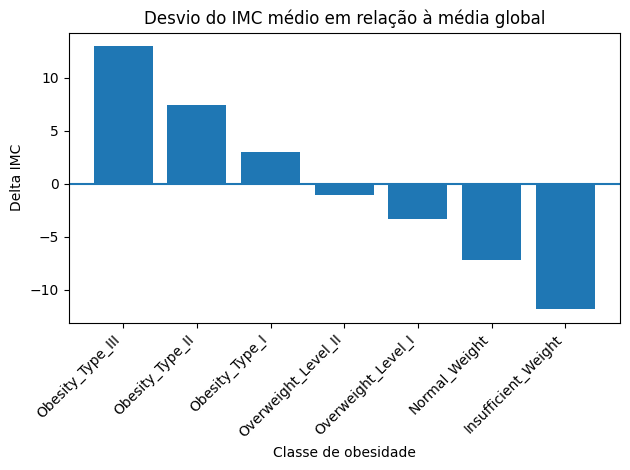

In [0]:
df_h4 = spark.sql(f"""
WITH base AS (
  SELECT
    nobeyesdad,
    media_bmi,
    AVG(media_bmi) OVER() AS bmi_medio_geral
  FROM {full_table_path_gold}
)
SELECT
  nobeyesdad,
  media_bmi - bmi_medio_geral AS delta_bmi
FROM base
ORDER BY delta_bmi DESC
""")

pdf = df_h4.toPandas()

plt.figure()
plt.bar(pdf["nobeyesdad"], pdf["delta_bmi"])
plt.axhline(0)
plt.xticks(rotation=45, ha="right")
plt.title("Desvio do IMC médio em relação à média global")
plt.ylabel("Delta IMC")
plt.xlabel("Classe de obesidade")
plt.tight_layout()
plt.show()


As classes mais severas apresentam IMC médio significativamente acima da média global da população analisada, enquanto classes menos severas ficam próximas ou abaixo dessa média. Esse resultado sustenta a hipótese H4 e demonstra que a análise por deltas permite identificar claramente os grupos que mais se afastam do perfil médio.

### Hipótese H5 – Risco agregado de obesidade

**O que a query mede**  
A consulta constrói um score de risco composto, combinando IMC médio, proporção de histórico familiar e proporção de consumo de alimentos calóricos, com pesos definidos para cada componente.

**O que foi observado**  
As classes de obesidade mais severa apresentam os maiores valores do score de risco, enquanto classes menos severas apresentam valores significativamente menores.

**O que isso significa no contexto do problema**  
O score sintetiza múltiplos fatores em um único indicador, evidenciando que a obesidade é um fenômeno multifatorial e que a combinação de fatores clínicos e comportamentais aumenta o risco agregado.

**Limitações**  
Os pesos utilizados no score são heurísticos e não estimados estatisticamente. O indicador não representa probabilidade, apenas um índice comparativo.


In [0]:
# Risco agregado – score composto (H5)
df_score = spark.sql(f"""
SELECT
  nobeyesdad,
  media_bmi,
  proporcao_historia_familiar,
  proporcao_favc,
  total_individuos,
  ROUND(
    (media_bmi / 40.0) * 0.5
    + proporcao_historia_familiar * 0.25
    + proporcao_favc * 0.25,
    4
  ) AS score_risco
FROM {full_table_path_gold}
ORDER BY score_risco DESC
""")

display(df_score)

top = df_score.take(1)
bottom = df_score.orderBy("score_risco").take(1)

if not top or not bottom:
    print("A consulta não retornou linhas.")
else:
    max_row = top[0]
    min_row = bottom[0]

    print(f"Maior score de risco agregado: {max_row['nobeyesdad']} "
          f"(score={max_row['score_risco']}).")
    print(f"Menor score de risco agregado: {min_row['nobeyesdad']} "
          f"(score={min_row['score_risco']}).")

    print(
        "Interpretação (H5): o score sintetiza fatores clínicos (IMC médio), familiares "
        "e comportamentais em um único indicador. Observa-se que classes mais severas "
        "apresentam maiores valores de risco agregado, reforçando o caráter multifatorial da obesidade."
    )

    print(
        "Limitações (H5): os pesos utilizados no score são heurísticos e não estimados "
        "estatisticamente. O indicador não representa probabilidade, apenas um índice comparativo."
    )


nobeyesdad,media_bmi,proporcao_historia_familiar,proporcao_favc,total_individuos,score_risco
Obesity_Type_III,42.27,1.0,0.9969,324,1.0276
Obesity_Type_II,36.72,0.9966,0.9764,297,0.9522
Obesity_Type_I,32.26,0.9801,0.9687,351,0.8905
Overweight_Level_II,28.22,0.9379,0.7448,290,0.7734
Overweight_Level_I,25.96,0.7572,0.9203,276,0.7439
Normal_Weight,22.01,0.539,0.7234,282,0.5907
Insufficient_Weight,17.39,0.4682,0.8127,267,0.5376


Maior score de risco agregado: Obesity_Type_III (score=1.0276).
Menor score de risco agregado: Insufficient_Weight (score=0.5376).
Interpretação (H5): o score sintetiza fatores clínicos (IMC médio), familiares e comportamentais em um único indicador. Observa-se que classes mais severas apresentam maiores valores de risco agregado, reforçando o caráter multifatorial da obesidade.
Limitações (H5): os pesos utilizados no score são heurísticos e não estimados estatisticamente. O indicador não representa probabilidade, apenas um índice comparativo.


### Interpretação 
- O score sintetiza fatores clínicos (IMC médio), familiares e comportamentais em um único indicador. Observa-se que classes mais severas apresentam maiores valores de risco agregado, reforçando o caráter multifatorial da obesidade.
- Limitações (H5): os pesos utilizados no score são heurísticos e não estimados estatisticamente. O indicador não representa probabilidade, apenas um índice comparativo.

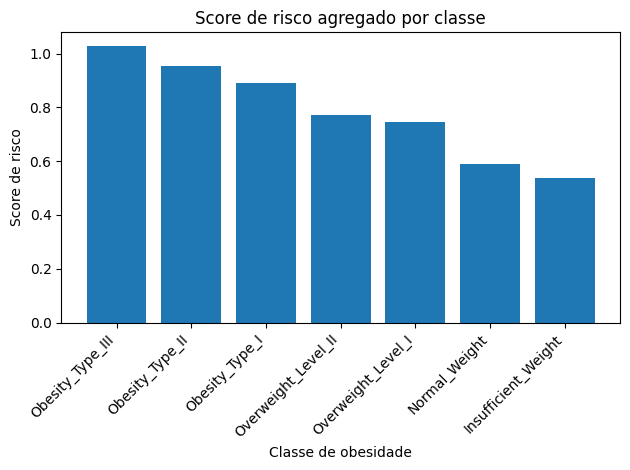

In [0]:
df_h5 = spark.sql(f"""
SELECT
  nobeyesdad,
  (media_bmi / 40.0) * 0.5
  + proporcao_historia_familiar * 0.25
  + proporcao_favc * 0.25 AS score_risco
FROM {full_table_path_gold}
ORDER BY score_risco DESC
""")

pdf = df_h5.toPandas()

plt.figure()
plt.bar(pdf["nobeyesdad"], pdf["score_risco"])
plt.xticks(rotation=45, ha="right")
plt.title("Score de risco agregado por classe")
plt.ylabel("Score de risco")
plt.xlabel("Classe de obesidade")
plt.tight_layout()
plt.show()


O score de risco composto apresentou valores mais elevados para as classes de obesidade mais severa, enquanto classes menos severas obtiveram scores inferiores. Esse resultado sustenta a hipótese H5 e evidencia que a obesidade é um fenômeno multifatorial, no qual a combinação de fatores clínicos, familiares e comportamentais aumenta o risco agregado.

In [0]:
# IMC médio global ponderado (indicador resumo)
df_global = spark.sql(f"""
SELECT
  ROUND(SUM(media_bmi * total_individuos) / SUM(total_individuos), 2) AS bmi_medio_ponderado
FROM {full_table_path_gold}
""")
display(df_global)
global_val = df_global.toPandas().iloc[0]['bmi_medio_ponderado']
print(f"IMC médio global ponderado: {global_val}.")
print("Interpretação: indicador único para resumir a base; serve como referência para comparar classes e para contextualizar a amostra (normal/sobrepeso/obesidade).")

bmi_medio_ponderado
29.77


IMC médio global ponderado: 29.77.
Interpretação: indicador único para resumir a base; serve como referência para comparar classes e para contextualizar a amostra (normal/sobrepeso/obesidade).


### Interpretação 
- Indicador único para resumir a base; serve como referência para comparar classes e para contextualizar a amostra (normal/sobrepeso/obesidade).

### 11) Discussão Final da Solução do Problema

A análise realizada a partir dos indicadores consolidados na camada Gold permitiu avaliar de forma estruturada as hipóteses H1–H5 definidas neste trabalho. Os resultados obtidos sustentam todas as hipóteses propostas, indicando que níveis mais elevados de obesidade estão associados a maiores valores de IMC médio, maior prevalência de histórico familiar de sobrepeso e maior frequência de consumo de alimentos muito calóricos.

As hipóteses H1 e H4 demonstraram coerência entre a classificação de obesidade e o IMC médio, tanto em termos absolutos quanto em relação à média global da população analisada. Classes mais severas apresentaram valores de IMC significativamente superiores, bem como desvios positivos em relação ao perfil médio, evidenciando maior gravidade clínica.

No que se refere aos fatores familiares e comportamentais, as hipóteses H2 e H3 indicaram que tanto o histórico familiar de sobrepeso quanto o consumo frequente de alimentos calóricos tendem a aumentar conforme a severidade da obesidade. Esses resultados sugerem que a obesidade, no conjunto de dados analisado, está associada não apenas a fatores individuais, mas também a padrões familiares e hábitos alimentares.

A análise de comportamentos ordinais (CAEC e CALC) mostrou tendência coerente com o aumento do IMC médio, reforçando a utilidade do tratamento realizado na camada Silver para viabilizar comparações numéricas desses comportamentos na camada Gold.

A hipótese H5, baseada na construção de um score de risco agregado, evidenciou que classes mais severas apresentam maiores níveis de risco quando se combinam fatores clínicos, familiares e comportamentais, reforçando o caráter multifatorial da obesidade.

Quanto ao impacto amostral, observou-se que a distribuição do número de indivíduos entre as classes influencia as médias globais e deve ser considerada na interpretação dos resultados, especialmente ao comparar classes mais numerosas com aquelas menos representadas.

Por fim, é importante destacar as limitações do estudo. O conjunto de dados utilizado é sintético e previamente curado, o que pode não refletir integralmente a variabilidade de uma população real. Além disso, a análise é descritiva e não permite inferir causalidade entre as variáveis analisadas. A ausência de informações socioeconômicas, nível de atividade física detalhado e outros fatores contextuais também limita a abrangência das conclusões. Ainda assim, os resultados obtidos atendem ao objetivo do MVP, demonstrando a capacidade do modelo de dados e das consultas analíticas em responder às perguntas propostas.


### Autoavaliação

O objetivo inicial deste trabalho foi analisar a relação entre fatores clínicos, familiares e comportamentais e os diferentes níveis de obesidade, utilizando uma arquitetura de dados em camadas e consultas analíticas para responder às perguntas de negócio propostas. Considera-se que esse objetivo foi plenamente atingido, uma vez que todas as hipóteses formuladas (H1–H5) foram avaliadas de forma estruturada e suportadas pelos indicadores obtidos.

Os principais pontos positivos do trabalho incluem a organização do pipeline de dados nas camadas Bronze, Silver e Gold, a análise explícita da qualidade dos dados, a construção de métricas analíticas coerentes e a discussão detalhada dos resultados, complementada por visualizações gráficas que facilitaram a interpretação das evidências.

Como pontos de melhoria, destaca-se que o conjunto de dados utilizado é sintético e previamente curado, o que limita a generalização dos resultados para cenários reais. Além disso, a ausência de variáveis socioeconômicas e de informações mais detalhadas sobre estilo de vida restringe a profundidade da análise. Em trabalhos futuros, a inclusão desses fatores e a aplicação de métodos estatísticos inferenciais poderiam enriquecer ainda mais as conclusões.

De forma geral, o trabalho atendeu aos objetivos propostos no início do MVP e permitiu consolidar conhecimentos sobre modelagem de dados, análise analítica e interpretação de resultados em um contexto de Data Warehouse/Lakehouse.
